In [73]:
import numpy as np
vmin = 0
vmax=1
levels=np.linspace(vmin,vmax,21)
import os
import sys
import re
import pandas as pd
import scipy
import csv
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import seaborn.apionly as sns
from matplotlib import cm
import glob
import matplotlib
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = 1
import statistics
from scipy.stats import sem
from MiRMAK import utils
from MiRMAK.utils import normalise_between_2_values
from MiRMAK.utils import normalise_0_1
import matplotlib.colors as mcolors
tum_blue4_as_python_color = np.array([0, 82, 147]) / 255
cmap = sns.light_palette(tum_blue4_as_python_color, as_cmap=True)
beads = ["C0433","C0434","C0435"]
from matplotlib.colors import LinearSegmentedColormap
cmap1 = LinearSegmentedColormap.from_list("my_colormap", ((0, 0, 0), (1, 1, 1)), N=6, gamma=1.0)
cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=len(levels)-1,
                                                 )
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import time
from scipy import interp
import pickle
import matplotlib.colors as colors
from scipy.stats import ttest_ind
from pylab import *

## functions
def create_colour_lists():
    '''
    Converts several lists of rgb colours to the python format (normalized to between 0 and 1)
    Returns a dictionary that contains dictionaries of palettes with named colours (eg. TUM blues)
    and also lists of unnamed colours (e.g. tableau20)
    (copied from tlabtools 2016.08.08)
    '''
    output_dict = {}

    matplotlib_150 = list(colors.cnames.values())
    output_dict['matplotlib_150'] = matplotlib_150

    #define colour dictionaries. TUM colours are based on the style guide.
    colour_dicts = {
                    'TUM_colours' : {
                                    'TUMBlue':(34,99,169),
                                    'TUM1':(100,160,200),
                                    'TUM2':(1,51,89),
                                    'TUM3':(42,110,177),
                                    'TUM4':(153,198,231),
                                    'TUM5':(0,82,147)
                                    },
                    'TUM_oranges': {
                        'TUM0': (202, 101, 10),
                        'TUM1': (213, 148, 96),
                        'TUM2': (102, 49, 5),
                        'TUM3': (220, 108, 11),
                        'TUM4': (247, 194, 148),
                        'TUM5': (160, 78, 8)
                    },
                    'TUM_accents' : {
                                    'green':(162,183,0),
                                    'orange':(227,114,34),
                                    'ivory':(218,215,203),
                                    }
                    }

    #convert the nested dicts to python 0 to 1 format
    for c_dict in colour_dicts:
        for c in colour_dicts[c_dict]:
            #define r, g, b as ints
            r, g, b = colour_dicts[c_dict][c]
            #normalise r, g, b and add to dict
            colour_dicts[c_dict][c] = (r / 255., g / 255., b / 255.)
        #add normalised colours to output dictionary
        output_dict[c_dict] = colour_dicts[c_dict]

    #define colour lists
    colour_lists = {
                    'tableau20' : [
                                 (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)
                                    ],
                    'tableau20blind' : [
                                         (0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
                                         (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
                                         (255, 188, 121), (207, 207, 207)
                                          ]
                    }
    #normalise the colours for the colour lists
    for rgb_list in colour_lists:
        colour_array = np.array(colour_lists[rgb_list])/255.
        colour_array_tup = tuple(map(tuple,colour_array))
        colour_lists[rgb_list] = colour_array_tup
        #add normalised colours to output dictionary
        output_dict[rgb_list] = colour_lists[rgb_list]
    #create a mixed blue/grey colour list, with greys in decreasing darkness
    TUM_colours_list_with_greys = []
    grey = 0.7
    for c in colour_dicts['TUM_colours'].values():
        TUM_colours_list_with_greys.append('%0.2f' % grey)
        TUM_colours_list_with_greys.append(c)
        grey -= 0.1
    output_dict['TUM_colours_list_with_greys'] = TUM_colours_list_with_greys

    output_dict['HTML_list01'] = ['#808080', '#D59460', '#005293', '#A1B11A', '#9ECEEC', '#0076B8', '#454545', "#7b3294", "#c2a5cf", "#008837", "#a6dba0"]
    return output_dict

def read_concat_wells(i,well,perc,df_out):
    df_file = r"Well_{}_Raw.csv".format(well)
    df = pd.read_csv(df_file, sep=';', decimal=',', skiprows=7,encoding="latin1")
#     create_contour_plot(well,perc,df)
#     create_diameter_pi_plot(well,perc,df)
    live_accuracy = 0
    dead_accuracy = 0
    live_accuracy, dead_accuracy = pi_accuracy(live_accuracy_list,dead_accuracy_list,well,perc,df)
    if i == 0:
        df["live"] = 1
    if i == 1:
        df["live"] = 0
    if df_out.empty:
        df_out = df
    else:
        df_out = pd.concat([df_out,df])
    return df_out, live_accuracy, dead_accuracy

def concat_df(df_all,df):
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
    return df_all

def pi_accuracy(live_accuracy_list,dead_accuracy_list,well,perc,df):
    df['PopID'] = df['PopID'].str.replace(',','.')
    df['PopID'] = df['PopID'].str.replace('#INF','000')
    df['PopID'] = df['PopID'].str.replace('#IND00','000')
    df['PopID'] = pd.to_numeric(df['PopID'])
    threshold = -1
    live_accuracy = 0
    dead_accuracy = 0
    if perc == "100":
        live_accuracy = df[df['PopID'] < threshold].shape[0]/df.shape[0]
    if perc == "0":
        dead_accuracy = df[df['PopID'] > threshold].shape[0]/df.shape[0]
    return live_accuracy, dead_accuracy
        

def create_diameter_pi_plot(well,perc,df):
    diameter_pi_png = r"D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\Contour\{}{}_pi.png".format(perc,well)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    df['PopID'] = df['PopID'].str.replace(',','.')
    df['PopID'] = df['PopID'].str.replace('#INF','000')
    df['PopID'] = df['PopID'].str.replace('#IND00','000')
    df['Algendurchmesser [µm]'] = pd.to_numeric(df['Algendurchmesser [µm]'])
    df['PopID'] = pd.to_numeric(df['PopID'])
    df.plot(x='Algendurchmesser [µm]', y='PopID', style='o')
    fig.tight_layout()
    plt.savefig(diameter_pi_png)
    
def create_contour_plot(well,perc,df):
    df['PopID'] = df['PopID'].str.replace(',','.')
    df['PopID'] = df['PopID'].str.replace('#INF','000')
    df['PopID'] = df['PopID'].str.replace('#IND00','000')
    x=df['X_wellbezogen [nm]']
    y=df['Y_wellbezogen [nm]']
    z=np.array(df.PopID.astype(float) - df.PopID.astype(float).min())
    # z=np.array(df['relativer Ligandenwert'])
    xi = np.linspace(x.min()-1, x.max()+1, 500)
    yi = np.linspace(y.min()-1, y.max()+1, 500)
    zi = griddata(x, y, z, xi, yi, interp='linear')
    contour_png = r"D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\Contour\{}{}.png".format(perc,well)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vmin = 0
    vmax=1
    levels=np.linspace(vmin,vmax,6)
    # CS = plt.contourf(xi, yi, zi, levels=levels, cmap=cmap,vmin =vmin,vmax=vmax, alpha=0.5)
    CS = plt.contourf(xi, yi, zi)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2, 2))
    plt.xlabel('X (nm)')
    plt.ylabel('Y (nm)')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(0.8, 0.9, 'right top', transform=ax.transAxes)
    fig.colorbar(CS)
    plt.scatter(x,y,marker='o',c='black',s=0.5,alpha=0.8)
    fig.tight_layout()
    plt.savefig(contour_png)
    plt.show()    

In [87]:
import matplotlib.colors as colors
print(list(colors.cnames.values()))

['#F0F8FF', '#FAEBD7', '#00FFFF', '#7FFFD4', '#F0FFFF', '#F5F5DC', '#FFE4C4', '#000000', '#FFEBCD', '#0000FF', '#8A2BE2', '#A52A2A', '#DEB887', '#5F9EA0', '#7FFF00', '#D2691E', '#FF7F50', '#6495ED', '#FFF8DC', '#DC143C', '#00FFFF', '#00008B', '#008B8B', '#B8860B', '#A9A9A9', '#006400', '#A9A9A9', '#BDB76B', '#8B008B', '#556B2F', '#FF8C00', '#9932CC', '#8B0000', '#E9967A', '#8FBC8F', '#483D8B', '#2F4F4F', '#2F4F4F', '#00CED1', '#9400D3', '#FF1493', '#00BFFF', '#696969', '#696969', '#1E90FF', '#B22222', '#FFFAF0', '#228B22', '#FF00FF', '#DCDCDC', '#F8F8FF', '#FFD700', '#DAA520', '#808080', '#008000', '#ADFF2F', '#808080', '#F0FFF0', '#FF69B4', '#CD5C5C', '#4B0082', '#FFFFF0', '#F0E68C', '#E6E6FA', '#FFF0F5', '#7CFC00', '#FFFACD', '#ADD8E6', '#F08080', '#E0FFFF', '#FAFAD2', '#D3D3D3', '#90EE90', '#D3D3D3', '#FFB6C1', '#FFA07A', '#20B2AA', '#87CEFA', '#778899', '#778899', '#B0C4DE', '#FFFFE0', '#00FF00', '#32CD32', '#FAF0E6', '#FF00FF', '#800000', '#66CDAA', '#0000CD', '#BA55D3', '#9370DB'

## parameters
1. diameter in µm (called “Durchmesser”)
2. area in pixel (called “Gesamtfläche”)
3. form factor (called “Formfaktor”) a number describing the roundness of the particle = the ratio of the max. radius and the min. radius of the object
4. fluorescence signals 1 and 2 (called “Kodierung 1” und “Kodierung 2”), For all viability assays with VideoScan the Syto 9 staining should be signal 1 and PI should be signal 2
5. PopID = logarithmic ratio between the two fluorescence signals


## Positive and negative wells
1. Projekt006139-15-01-24-AB_RR_Algen_LebendTot  
    A1,B1,C1(positive,all living)  
    H5,A6,B6(negative,all dead)  
2. Projekt006141-16-01-2014-AB_RR_Algen_LebendTot  
    E6,F6,G6(positive,all living)  
    G8,H8,A9(negative,all dead)  

In [24]:
df_pstv.columns

Index(['Algen-ID', 'BildID', 'Z [nm]', 'Gesamtfläche [Pixel]',
       'Algendurchmesser [µm]', 'Schwerpunkt_X_bildbezogen [Pixel]',
       'Schwerpunkt_Y_bildbezogen [Pixel]', 'X_wellbezogen [nm]',
       'Y_wellbezogen [nm]', 'Maximaler Radius [Pixel]',
       'Minimaler Radius [Pixel]', 'Formfaktor MaxRad/MinRad', 'Unnamed: 12',
       'Kodierung1_Belichtungszeit [µs]', 'Kodierung1_Achteck',
       'Kodierung1_Hintergrund', 'Kodierung1_Achteck/Belichtungszeit-normiert',
       'Kodierung1_Achteck/Größen-Belichtungszeit-normiert', 'Unnamed: 18',
       'Kodierung2_Belichtungszeit [µs]', 'Kodierung2_Achteck',
       'Kodierung2_Hintergrund', 'Kodierung2_Achteck/Belichtungszeit-normiert',
       'Kodierung2_Achteck/Größen-Belichtungszeit-normiert', 'Unnamed: 24',
       'PopID', 'Populationsindex', 'Populationsname', 'Unnamed: 28',
       'Belichtungszeit Ligand [µs]', 'absoluter Ligandenwert',
       'Hintergrund Ligand', 'relativer Ligandenwert', 'live'],
      dtype='object')

In [132]:
features = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
        'Kodierung1_Achteck',
       'Kodierung1_Hintergrund', 'Kodierung1_Achteck/Belichtungszeit-normiert',
       'Kodierung1_Achteck/Größen-Belichtungszeit-normiert',
       'Kodierung2_Achteck',
       'Kodierung2_Hintergrund', 'Kodierung2_Achteck/Belichtungszeit-normiert',
       'Kodierung2_Achteck/Größen-Belichtungszeit-normiert', 'PopID','live']
features1 = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
        'live']
features2 = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad']
features3 = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
        'Kodierung1_Achteck',
       'Kodierung1_Hintergrund', 'Kodierung1_Achteck/Belichtungszeit-normiert',
       'Kodierung1_Achteck/Größen-Belichtungszeit-normiert',
       'Kodierung2_Achteck',
       'Kodierung2_Hintergrund', 'Kodierung2_Achteck/Belichtungszeit-normiert',
       'Kodierung2_Achteck/Größen-Belichtungszeit-normiert', 'PopID']
dirs = [
       "D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\Projekt006141-16-01-2014-AB_RR_Algen_LebendTot_Results",
       "D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\Projekt006139-15-01-2014-AB_RR_Algen_LebendTot_Results"
       ]
pstv_wells_list = [["E6","F6","G6", "B9","C9","D9"],["A1","B1","C1", "F3","G3","H3"]]
ngtv_wells_list = [["G8","H8","A9","D11","E11","F11"],["C3","D3","E3","H5","A6","B6"]]
pec80_wells_list = [["H6","A7","B7","E9","F9","G9"],["D1","E1","F1","A4","B4","C4"]]
pec60_wells_list = [["C7","D7","E7","H9","A10","B10"],["G1","H1","A2","D4","E4","F4"]]
pec50_wells_list = [["F7","G7","H7","C10","D10","E10"],["B2","C2","D2","G4","H4","A5"]]
pec40_wells_list = [["A8","B8","C8","F10","G10","H10"],["E2","F2","G2","B5","C5","D5"]]
pec20_wells_list = [["D8","E8","F8","A11","B11","C11"],["H2","A3","B3","E5","F5","G5"]]
df_all_all = pd.DataFrame()
df_pstv_all = pd.DataFrame()
df_ngtv_all = pd.DataFrame()
df_80_all = pd.DataFrame()
df_60_all = pd.DataFrame()
df_50_all = pd.DataFrame()
df_40_all = pd.DataFrame()
df_20_all = pd.DataFrame()
df0 = pd.DataFrame()
live_accuracy_list = []
dead_accuracy_list = []
for i, dir in enumerate(dirs):
    os.chdir(dir)
    pstv_wells = pstv_wells_list[i]
    ngtv_wells = ngtv_wells_list[i]
    pec80_wells = pec80_wells_list[i]
    pec60_wells = pec60_wells_list[i]
    pec50_wells = pec50_wells_list[i]
    pec40_wells = pec40_wells_list[i]
    pec20_wells = pec20_wells_list[i]
    wells_list = [pstv_wells_list[i],ngtv_wells_list[i],pec80_wells_list[i],pec60_wells_list[i],pec50_wells_list[i]
            ,pec40_wells_list[i],pec20_wells_list[i]]
    perc_list = ["100","0","80","60","50","40","20"]
    df_pstv = pd.DataFrame()
    df_ngtv = pd.DataFrame()
    df_all = pd.DataFrame()
    df_80 = pd.DataFrame()
    df_60 = pd.DataFrame()
    df_50 = pd.DataFrame()
    df_40 = pd.DataFrame()
    df_20 = pd.DataFrame()
    df_out_list = [df_pstv,df_ngtv,df_80,df_60,df_50,df_40,df_20]
    for j,wells in enumerate(wells_list):
        for well in wells:
            df_out_list[j], live_accuracy, dead_accuracy = read_concat_wells(j,well,perc_list[j],df_out_list[j])
            live_accuracy_list.append(live_accuracy)
            dead_accuracy_list.append(dead_accuracy)
    df_pstv,df_ngtv,df_80,df_60,df_50,df_40,df_20 = df_out_list  
#     df_pstv.loc[df_pstv.PopID < -1.0,'live'] = 1
#     df_pstv.loc[df_pstv.PopID > -1.0,'live'] = 0
#     df_ngtv.loc[df_ngtv.PopID < -1.0,'live'] = 1
#     df_ngtv.loc[df_ngtv.PopID > -1.0,'live'] = 0
#     df_pstv = df_pstv[df_pstv.PopID < -1.0]
#     df_ngtv = df_ngtv[df_ngtv.PopID > -1.0]
    df_all = pd.concat([df_pstv,df_ngtv])
#     df_all['PopID'] = df_all['PopID'].str.replace(',','.')
#     df_all['PopID'] = df_all['PopID'].str.replace('#INF','000')
    df_all = df_all[features]
    df_pstv_all = concat_df(df_pstv_all,df_pstv)
    df_ngtv_all = concat_df(df_ngtv_all,df_ngtv)
    df_all_all = concat_df(df_all_all,df_all)
    df_80_all = concat_df(df_80_all,df_80)
    df_60_all = concat_df(df_60_all,df_60)
    df_50_all = concat_df(df_50_all,df_50)
    df_40_all = concat_df(df_40_all,df_40)
    df_20_all = concat_df(df_20_all,df_20)
#     df_pstv_all['PopID'] = df_pstv_all['PopID'].str.replace(',','.')
#     df_pstv_all['PopID'] = df_pstv_all['PopID'].str.replace('#INF','000')
#     df_pstv_all['PopID'] = df_pstv_all['PopID'].str.replace('#IND00','000')
#     df_ngtv_all['PopID'] = df_ngtv_all['PopID'].str.replace(',','.')
#     df_ngtv_all['PopID'] = df_ngtv_all['PopID'].str.replace('#INF','000')
#     df_ngtv_all['PopID'] = df_ngtv_all['PopID'].str.replace('#IND00','000')
#     df_80_all['PopID'] = df_80_all['PopID'].str.replace(',','.')
#     df_80_all['PopID'] = df_80_all['PopID'].str.replace('#INF','000')
#     df_80_all['PopID'] = df_80_all['PopID'].str.replace('#IND00','000')
#     df_60_all['PopID'] = df_60_all['PopID'].str.replace(',','.')
#     df_60_all['PopID'] = df_60_all['PopID'].str.replace('#INF','000')
#     df_60_all['PopID'] = df_60_all['PopID'].str.replace('#IND00','000')
#     df_50_all['PopID'] = df_50_all['PopID'].str.replace(',','.')
#     df_50_all['PopID'] = df_50_all['PopID'].str.replace('#INF','000')
#     df_50_all['PopID'] = df_50_all['PopID'].str.replace('#IND00','000')
#     df_40_all['PopID'] = df_40_all['PopID'].str.replace(',','.')
#     df_40_all['PopID'] = df_40_all['PopID'].str.replace('#INF','000')
#     df_40_all['PopID'] = df_40_all['PopID'].str.replace('#IND00','000')
#     df_20_all['PopID'] = df_20_all['PopID'].str.replace(',','.')
#     df_20_all['PopID'] = df_20_all['PopID'].str.replace('#INF','000')
#     df_20_all['PopID'] = df_20_all['PopID'].str.replace('#IND00','000')
    df_80_all,df_60_all,df_50_all,df_40_all,df_20_all = [df_80_all[features3],df_60_all[features3],df_50_all[features3]
                                                         ,df_40_all[features3],df_20_all[features3]]
os.chdir("D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae")
print(df_all_all.shape)


C:\Users\zengb\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



(90617, 15)


In [128]:
print(sum(live_accuracy_list)/12,sum(dead_accuracy_list)/12)

0.9505964704886622 0.9503008018631179


In [3]:
print(df_pstv_all.shape,df_ngtv_all.shape)

(50337, 34) (40280, 34)


In [141]:
##training the classifier and run cross-validation
from sklearn.metrics import confusion_matrix
X = df_all_all.drop('live', 1)
y = df_all_all['live']
skf = StratifiedKFold(n_splits=10)
cv = list(skf.split(X, y))
n_features = X.shape[1]
min_samples_leaf=3
max_depth=30
max_features=0.3
random_state=42
crossvalidation_pkl = os.path.join("10F_data.pkl")
features_csv = os.path.join("test_features.csv")
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# save all outputs to a cross-validation dictionary, to be saved as a pickle file
xv_dict = {}
forest = ExtraTreesClassifier(n_estimators=200, n_jobs=4, criterion="entropy",
                                        min_samples_leaf=min_samples_leaf,
                                        max_depth=max_depth,
                                        max_features=max_features,
                                        random_state=random_state
                                        )
start = time.clock()
accuracy_list = []
for i, (train, test) in enumerate(cv):
    sys.stdout.write("f{}.".format(i + 1)), sys.stdout.flush()
    probas_ = forest.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    binaris_ = forest.fit(X.iloc[train], y.iloc[train]).predict(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1], drop_intermediate=False)
    tn, fp, fn, tp = confusion_matrix(y.iloc[test], binaris_).ravel()
#                 print(tp,tn,fp,fn)
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    accuracy_list.append(accuracy)
    xv_dict["fpr{}".format(i)] = fpr
    xv_dict["tpr{}".format(i)] = tpr
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
sys.stdout.write("\n"), sys.stdout.flush()
sys.stdout.write("tree depths : {}".format([estimator.tree_.max_depth for estimator in forest.estimators_]))

duration = time.clock() - start

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_acc = mean(accuracy_list)

xv_dict["true_positive_rate_mean"] = mean_tpr
xv_dict["false_positive_rate_mean"] = mean_fpr
xv_dict["mean_auc"] = mean_auc

# save dict as pickle
with open(crossvalidation_pkl, "wb") as f:
    pickle.dump(xv_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

features_ser = pd.Series(X.columns)
features_ser.to_csv(features_csv)
sys.stdout.write('10-fold validation. AUC({:.3f}). mean accuracy :{}. Time taken = {:.2f}.\nFeatures: {}'.format( mean_auc,mean_acc,
                                                                                             duration,X.columns.tolist()))

f1.f2.f3.f4.f5.f6.f7.f8.f9.f10.
tree depths : [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]10-fold validation. AUC(0.990). mean accuracy :0.9634060749780705. Time taken = 75.62.
Features: ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]', 'Maxima

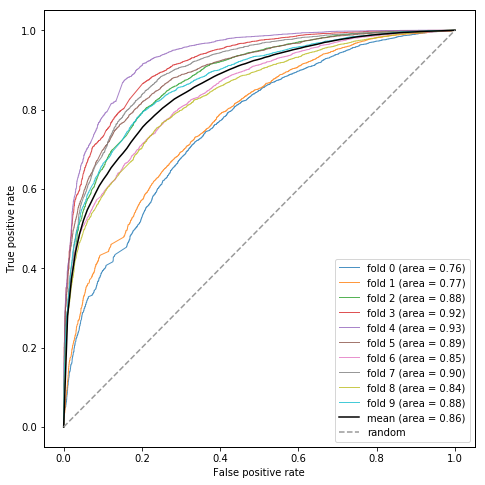

In [118]:
##plot the cross validation plots
crossvalidation_png = os.path.join("10F_ROC.png")
with open(crossvalidation_pkl, "rb") as f:
    xv_dict = pickle.load(f)

figsize = np.array([3.42, 3.42]) * 2  # DOUBLE the real size
fig, ax = plt.subplots(figsize=figsize)
for i in range(10):
    roc_auc = auc(xv_dict["fpr{}".format(i)], xv_dict["tpr{}".format(i)])
    ax.plot(xv_dict["fpr{}".format(i)], xv_dict["tpr{}".format(i)], lw=1, label='fold %d (area = %0.2f)' % (i, roc_auc), alpha=0.8)

mean_auc = xv_dict["mean_auc"]

ax.plot(xv_dict["false_positive_rate_mean"], xv_dict["true_positive_rate_mean"], color="k",
        label='mean (area = %0.2f)' % mean_auc, lw=1.5)

ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='random')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(crossvalidation_png, dpi=240)
# fig.savefig(crossvalidation_png[:-4] + ".pdf")
# fig.savefig(MiRMAK.utils.pdf_subpath(crossvalidation_png))

1. feature 3 (0.326631) Minimaler Radius [Pixel]2. feature 1 (0.196204) Algendurchmesser [µm]3. feature 0 (0.174685) Gesamtfläche [Pixel]4. feature 2 (0.101772) Maximaler Radius [Pixel]5. feature 4 (0.080707) Formfaktor MaxRad/MinRad



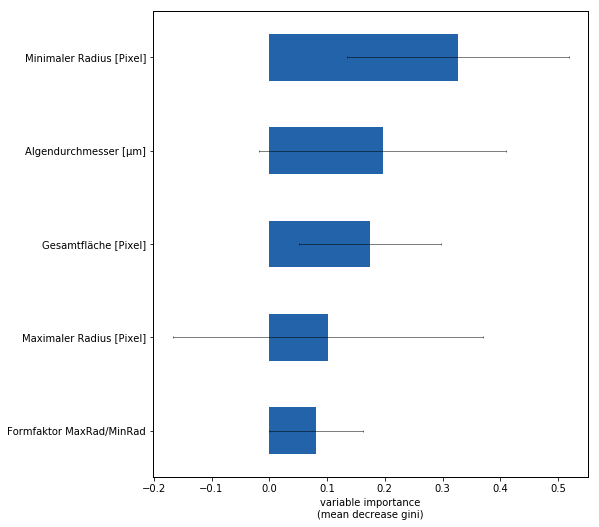

In [119]:
## plot the variable importances
variable_importance_csv = os.path.join("variable_importance.csv")
variable_importance_png = os.path.join("var_import.png")
importances_arr = forest.feature_importances_
std_arr = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices_arr = np.argsort(importances_arr)[::-1]

importances_text_list = X.columns.tolist()
output_dfs = []
#order_list = [importances_arr[indices_arr[f]] for f in range(X.shape[1])]
nested_dict = {}
for f in range(X.shape[1]):
    if f < 10 :
        sys.stdout.write("%d. feature %d (%f) %s" % (f + 1, indices_arr[f], importances_arr[indices_arr[f]], importances_text_list[indices_arr[f]]))
    single_feature_dict = {"original_order" : indices_arr[f], "mean_decrease_gini" : importances_arr[indices_arr[f]], "feature" : importances_text_list[indices_arr[f]],  "std" : std_arr[f]}
    nested_dict[f + 1] = single_feature_dict

sys.stdout.write("\n\n"), sys.stdout.flush()
df_imp = pd.DataFrame(nested_dict).T
df_imp["order_importance"] = df_imp.index
#df_imp.set_index("feature", inplace=True)
df_imp.set_index("original_order", inplace=True)
output_dfs.append(df_imp)
df_imp2 = pd.concat(output_dfs, axis=1)
df_imp2.sort_values("order_importance", inplace=True)
df_imp2["original_order"] = df_imp2.index
df_imp2.set_index("feature", inplace=True)
df_imp2.to_csv(variable_importance_csv)
df_imp = pd.read_csv(variable_importance_csv, index_col = 0)
n_features_in_plot = df_imp.shape[0]
df_sel = df_imp.iloc[:n_features_in_plot, :].copy()
df_sel.sort_values("mean_decrease_gini", ascending=True, inplace=True)
plot_height = 4 * n_features_in_plot / 30
figsize = np.array([8.42, 7.42])
fig, ax = plt.subplots(figsize=figsize)
colour_dict = create_colour_lists()
TUMblue = colour_dict["TUM_colours"]['TUMBlue']
df_sel["mean_decrease_gini"].plot(kind="barh", color=TUMblue, ax=ax)# xerr=df_sel["std"]
ax.errorbar(df_sel["mean_decrease_gini"], range(len(df_sel.index)), xerr=df_sel["std"], fmt="none", ecolor="k", ls="none", capthick=0.5, elinewidth=0.5, capsize=1, label=None)

ax.set_ylabel("")
ax.set_xlabel("variable importance\n(mean decrease gini)")
ax.grid(False)
fig.tight_layout()
fig.savefig(variable_importance_png, dpi=240)

In [120]:
##train the classifier with all train data
X_train = df_all_all.drop('live', 1)
y_train = df_all_all['live']
n_features = X_train.shape[1]
forest = ExtraTreesClassifier(n_estimators=200, n_jobs=4, criterion="entropy",
                                        min_samples_leaf=3,
                                        max_depth=30,
                                        max_features=0.3,
                                        random_state=42
                                        )
fitted = forest.fit(X_train, y_train)



r_value 0.9691591062706421 and p_value 0.006471499648278217


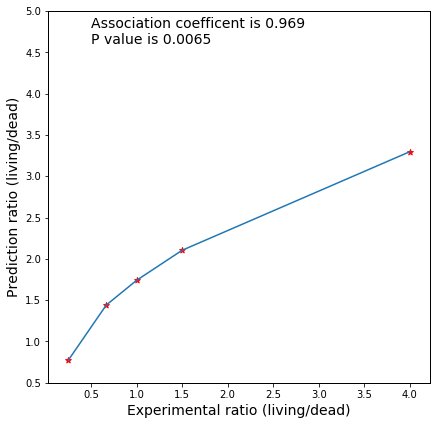

In [121]:
###plot the linear correlation between experimental and prediction ratio
# prediction = fitted.predict_proba(X_test)[:, 1]
df_list = [df_80_all,df_60_all,df_50_all,df_40_all,df_20_all]
ratio_pred = []
for X_test in df_list:
    prediction = list(fitted.predict(X_test))
    ratio_pred.append(prediction.count(1)/prediction.count(0))  
ratio_exp = [80/20,60/40,50/50,40/60,20/80]
r_value,p_value = scipy.stats.pearsonr(ratio_exp, ratio_pred)
print("r_value {} and p_value {}".format(r_value,p_value))
exp_pred_ratio_png = "Experiment_predict_live_dead_ratio.png"
figsize = np.array([3.42, 3.42]) * 2 # DOUBLE the real size, due to problems on Bo computer with fontsizes
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ratio_exp,ratio_pred)
ax.scatter(ratio_exp,ratio_pred,marker='*',color='red')
ax.set(yticks=[0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0])
ax.set_ylabel("Prediction ratio (living/dead)", fontsize=14)
ax.set_xlabel("Experimental ratio (living/dead)", fontsize=14)
plt.text(0.5,4.6,"Association coefficent is %.3f\nP value is %.4f" % (r_value,p_value),fontsize=14)
plt.savefig(exp_pred_ratio_png)
plt.show()

In [92]:
print(ratio_exp,ratio_pred)

[4.0, 1.5, 1.0, 0.6666666666666666, 0.25] [4.959092646871416, 1.688576933663639, 1.0240401549841494, 0.8827192735746715, 0.34095292295045687]


PosMean:3.617849109666632,NegMean:5.965563201109425,Pvalue:0.0
PosMean:8.041582333368167,NegMean:10.950023972290545,Pvalue:0.0
PosMean:165.25534538614275,NegMean:316.34342456434143,Pvalue:0.0
PosMean:4.124668793207232,NegMean:5.825778176932336,Pvalue:0.0


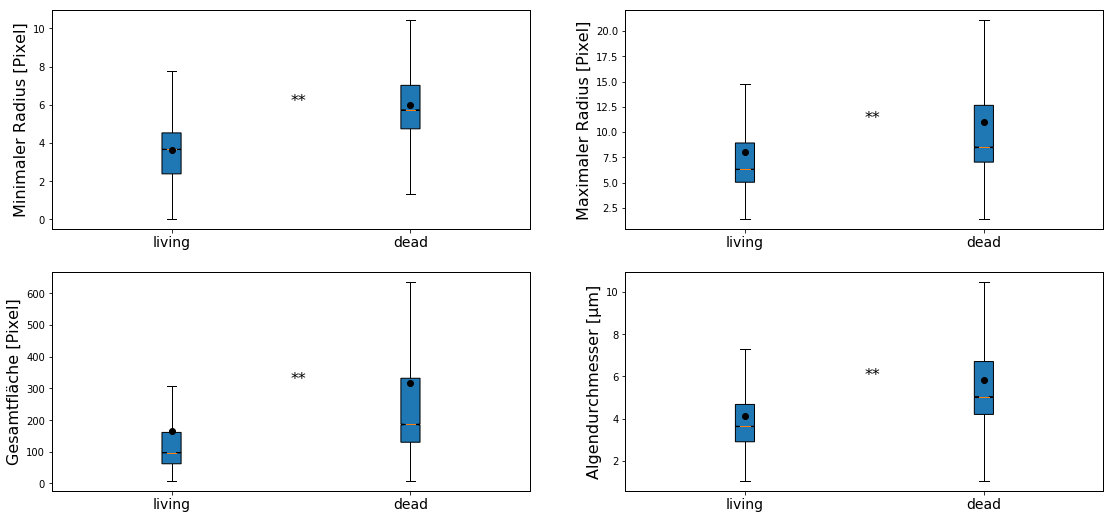

In [122]:
### boxplot of morphology features living vs dead
meanpointprops = dict(marker='o', markeredgecolor='black',markerfacecolor='black')
morphs = ['Minimaler Radius [Pixel]','Maximaler Radius [Pixel]','Gesamtfläche [Pixel]','Algendurchmesser [µm]']
# fig = plt.figure()
morpho_feature_comp = "morphology_living_dead_compare.png"
figsize = np.array([9.42, 4.42]) * 2  # DOUBLE the real size
fig, ax = plt.subplots(figsize=figsize)
for i, morph in enumerate(morphs):
#     ax = fig.add_subplot(111)

    ax = plt.subplot(2, 2,i+1)
#     subplot(2,3,i+1)
    ax.boxplot([np.array(df_pstv_all[morph]),np.array(df_ngtv_all[morph])],1, '', 1, widths=0.08,
                meanprops=meanpointprops, showmeans=True, meanline=False, autorange=True,
                    patch_artist=True)
    ax.set_ylabel("{}".format(morph),fontsize=16)
    ax.set(xticks=[1,2],xticklabels=["living","dead"])
    plt.xticks(fontsize=14)
    plt.text(1.5,np.mean(np.array(df_ngtv_all[morph])),"**",fontsize=16)
    t_value, p_value = ttest_ind(df_pstv_all[morph], df_ngtv_all[morph])
    print("PosMean:{},NegMean:{},Pvalue:{}".format(np.mean(np.array(df_pstv_all[morph])),np.mean(np.array(df_ngtv_all[morph])),p_value))
plt.savefig(morpho_feature_comp)

In [42]:
np.mean(np.array(df_ngtv_all[morph]))

5.617254418545183

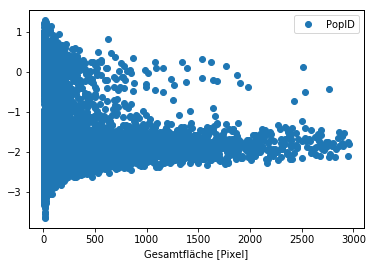

In [63]:
df_pstv_all['Gesamtfläche [Pixel]'] = pd.to_numeric(df_pstv_all['Gesamtfläche [Pixel]'])
df_pstv_all['PopID'] = pd.to_numeric(df_pstv_all['PopID'])
df_pstv_all.plot(x='Gesamtfläche [Pixel]', y='PopID', style='o')

In [59]:
features = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
           'relativer Ligandenwert']

for feature in features:
    df_pstv_all.plot(x=feature, y='PopID', style='o')
# df.plot(x='Gesamtfläche [Pixel]', y='PopID', style='o')
# df.plot(x='', y='PopID', style='o')
# df_pstv_all.plot(x='Algendurchmesser [µm]', y='Gesamtfläche [Pixel]', style='o')

ValueError: could not convert string to float: 'Algen (alle)'

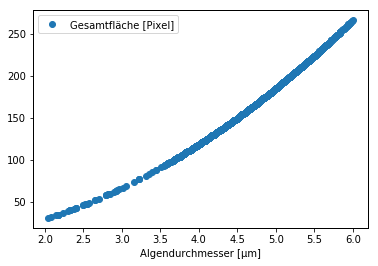

In [62]:
df1.plot(x='Algendurchmesser [µm]', y='Gesamtfläche [Pixel]', style='o')